In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import tqdm
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

FileNotFoundError: [Errno 2] No such file or directory: 'data_train.pickle'

TypeError: 'NoneType' object is not subscriptable

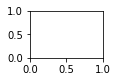

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [7]:
# Подготовка датасета
# Подготовим файлы датасета

with open('./data_train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('./data_test_no_labels.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

# Отнормируем данные

x = train['data']
y = train['target']
x = x.astype('float')

xm = np.mean(x, axis = 0)
xs = np.std(x, axis = 0)


x_train, x_val, y_train, y_val = \
    train_test_split((x - np.mean(x))/(np.std(x) + 0.01), y, test_size = 0.15, random_state=10, stratify = y)
x = (x - xm) / (xs + 0.001)

FileNotFoundError: [Errno 2] No such file or directory: './data_train.pickle'

In [8]:
# Определение слоев сети
# class Dense:
# Реализуем по аналогии с лекцией

class Dense:
    
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001): ###
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx

In [42]:
# Определение слоев сети
# class Max:
# Реализуем по аналогии с лекцией

class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.01): ###
        dz[self.x < 0] = 0
        return dz

In [43]:
# Определение слоев сети
# class  SoftMax:
# Реализуем по аналогии с лекцией

class SoftMax:
    
    def forward(self, x):
        self.x = x
        exp = np.exp(x)
        return exp / np.sum(exp)

    def backward(self, dz, lr = 0.002): ###
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [44]:
# Определим loss-функцию CrossEntropy
# class CrossEntropy:

class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr = 0.001): ###
        return -dz * self.y_true / self.y_hat

In [45]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [46]:
# Опеределение самой сети
# class MnistNet:

class MnistNet:
    
    def __init__(self, rlambda=0.0009):
        self.d_1 = Dense(x_train.shape[1], 140, rlambda) ###
#         self.dr = Dropout(0.5)
        self.m1 = Max()
        self.d_2 = Dense(140, 10, rlambda) ###
#         self.m2 = Max()
#         self.d_3 = Dense(100, 10, rlambda)
        self.s = SoftMax()
    
    def forward(self, x):
        net = self.d_1.forward(x)
#         net = self.dr.forward(net)
        net = self.m1.forward(net)
        net = self.d_2.forward(net)
#         net = self.m2.forward(net)
#         net = self.d_3.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr=1e-3):
        dz = self.s.backward(dz, lr)
#         dz = self.d_3.backward(dz, lr)
#         dz = self.m2.backward(dz, lr)
        dz = self.d_2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
#         dz = self.dr.backward(dz, lr)
        dz = self.d_1.backward(dz, lr)
        return dz


In [47]:
# Здесь процедура обучения
# net = MnistNet()
# loss = CrossEntropy()

net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
acc_train = []
acc_test = []
encdr = OneHotEncoder()
for iter in tqdm.tqdm_notebook(range(30)):
   # if (iter == 7):
  #      lr = 0.0005
    L_acc = 0.
    sh = list(range(x_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(x_train.shape[0]):
#        net.dr.set_train(True)
        x = x_train[sh[i]]
        y = encdr.transform(y_train[sh[i]])
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(x_val.shape[0]):
#        net.dr.set_train(False)
        x = x_val[i]
        y = encdr.transform(y_val[i])
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= y_val.shape[0]
    L_test.append(L_e_acc)
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))
    acc_train.append(compute_acc(x_train, y_train, net)) # Добавлено
    acc_test.append(compute_acc(x_val, y_val, net)) # Добавлено


0 iter loss. Train : 0.2793743451288234 . Test : 0.179752286157462
1 iter loss. Train : 0.13866480219790825 . Test : 0.13843233249685774
2 iter loss. Train : 0.10105878705187155 . Test : 0.11548819548881507
3 iter loss. Train : 0.07829953595044033 . Test : 0.1047441823000444
4 iter loss. Train : 0.06360810775576248 . Test : 0.09553423771042081
5 iter loss. Train : 0.05248656879827127 . Test : 0.0897632536017575
6 iter loss. Train : 0.04394715082152043 . Test : 0.08615530313210858
7 iter loss. Train : 0.03687929835907537 . Test : 0.08683865463652421
8 iter loss. Train : 0.031870912118802594 . Test : 0.08130607502405365
9 iter loss. Train : 0.02714670818711128 . Test : 0.08361089753739281
10 iter loss. Train : 0.023523498593078708 . Test : 0.07866312771366388
11 iter loss. Train : 0.020569631807527175 . Test : 0.07835799349964767
12 iter loss. Train : 0.017649826471195104 . Test : 0.07703336440563689
13 iter loss. Train : 0.015441556260595686 . Test : 0.0770272624414752
14 iter loss. Tra

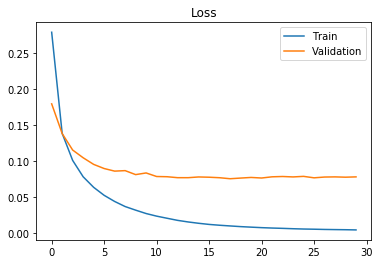

In [48]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
# plot(L_train, label="train")
plt.title('Loss')
plt.plot(L_train, label = 'Train')
plt.plot(L_test, label = 'Validation')
plt.legend();

1.0
0.9794285714285714


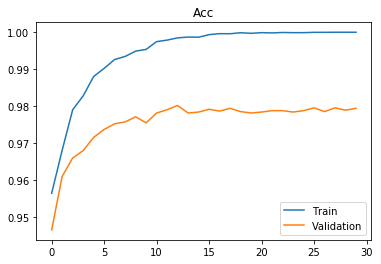

In [49]:
# Добавил график для Accuracy
plt.title('Acc')
plt.plot(acc_train, label='Train')
plt.plot(acc_test, label='Validation')
plt.legend();
print(compute_acc(x_train, y_train, net))
print (compute_acc(x_val, y_val,net))

In [50]:
# формируем сабмишшен и заливаем его на kaggle
xx = test_no_lables['data']


xx = xx.astype('float')
xx = (xx - xm) / (xs + 0.00001)


make_submission(xx, net)Я

/home/archie/environments/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/archie/environments/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [1]:
I = train_data['data'][150]
I = I.reshape((28, 28))

plt.imshow(I, cmap = 'gray')

NameError: name 'train_data' is not defined

In [52]:
y_h = net.forward(train_data['data'][160])
y = np.argmax(y_h)
y


/home/archie/environments/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/archie/environments/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


3